In [ ]:
import os
import random
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def play_audio(x, sr):
  wn = Audio(x, rate = sr, autoplay=True); display(wn)

def show_waveform(x, title = ''):
  plt.plot(x); plt.title(title); plt.xticks([]); plt.yticks([]); plt.show()

def show_spec(spec, sr, title = ''):
  librosa.display.specshow(spec, sr=sr);
  plt.title(category); plt.show()

In [ ]:
# convertion to spectrograms

def parallel_CNN_spectrogram(x):
  stft = np.abs(librosa.stft(x, n_fft=1024, hop_length=128))**2
  log_stft = librosa.power_to_db(stft)
  melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
  return melsp


def sequential_CNN_spectrogram(x_clip):
  hp_l= 108 # creates 256 samples in the time domain.
  n_m = 256
  NFFT=1024*2
  trunc_mel= 256  # number of mels filters

  mel_feat = librosa.feature.melspectrogram(y=x_clip,sr=22050,
                                        n_fft= NFFT,
                                        hop_length= hp_l,
                                        win_length= NFFT,
                                        window='hann',
                                        center=True,
                                        power=2, pad_mode='constant', n_mels=n_m)

  mel_feat=mel_feat[0:trunc_mel,:]  # Truncation number of mel filters
  spec = librosa.power_to_db(mel_feat, ref=1e-3)
  return spec

## Setup

In [ ]:
# LINK TO DRIVE FOLDER: https://drive.google.com/drive/folders/1YCoFrWIGGb1wn78FRO9rd2x2bSdoDw5l?usp=sharing

home_folder = '/content/drive/MyDrive/HDA_project/'

filepath_sequential_CNN = home_folder + 'best_models/sequential_CNN.h5'
filepath_parallel_CNN = home_folder + 'best_models/model3_esc50.hdf5'

filepath_audio = home_folder + 'data/audio/audio/44100/'
filepath_metadata = home_folder + 'data/esc50.csv'

## see one sample

In [ ]:
df = pd.read_csv(filepath_metadata)

class_dict = {}
for i in range(2000):
    if df.loc[i,"target"] not in class_dict.keys():
        class_dict[df.loc[i,"target"]] = df.loc[i,"category"]

In [ ]:
###

I = 7

filepath = df.loc[I, "filename"]
category = df.loc[I,"category"]
target = df.loc[I,"target"]

x, _ = librosa.load(filepath_audio + filepath, sr=44100)

In [ ]:
play_audio(x, sr = 44100)

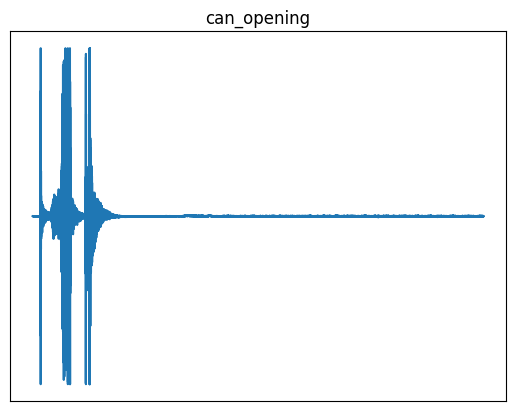

In [ ]:
show_waveform(x, title = category)

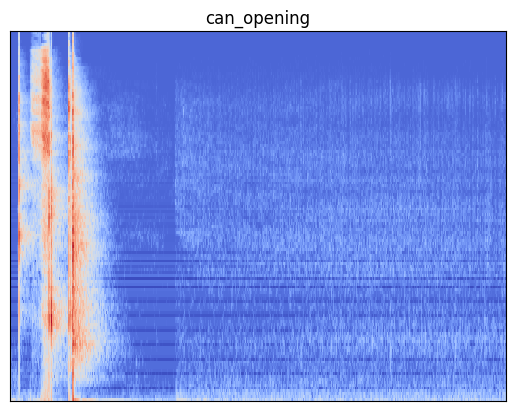

In [ ]:
spec = parallel_CNN_spectrogram(x)
show_spec(spec, sr = 44100)

## sequential CNN

In [ ]:
x_ = librosa.resample(x, orig_sr=44100, target_sr=22050)

In [ ]:
# select 1.25s with highest intensity

from skimage import util

sub_sequence= 22050*1.25    #  1.25 seconds of signal !
st=400 # step
audio_data_red = []

def choose_highest_intensity_frame(x):
  frames = util.view_as_windows(x, window_shape=(sub_sequence,), step=st)
  frame_intensity = []
  for frame in frames:
      frame_intensity.append(frame @ frame)
  optim_frame_index = np.array(frame_intensity).argmax()
  x_clip = frames[optim_frame_index]/np.max(frames[optim_frame_index])
  return x_clip

x_clip = choose_highest_intensity_frame(x_)

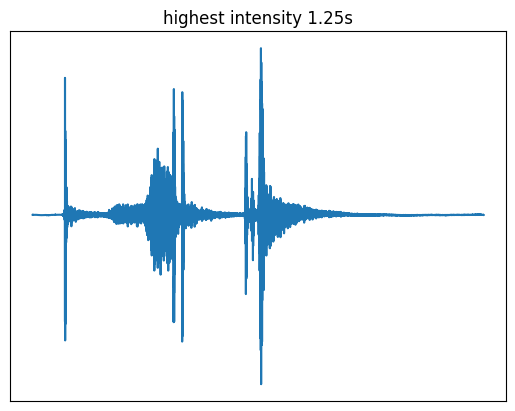

In [ ]:
show_waveform(x_clip, title = 'highest intensity 1.25s')

1/1 [==============================] - 0s 158ms/step


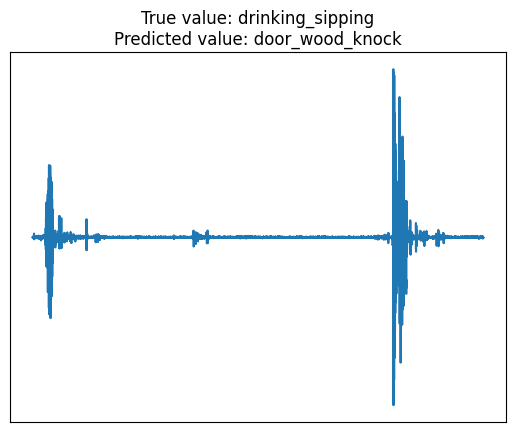

In [ ]:
I = 524

filepath = df.loc[I, "filename"]
category = df.loc[I,"category"]
target = df.loc[I,"target"]

x, _ = librosa.load(filepath_audio + filepath, sr=44100)
x_ = librosa.resample(x, orig_sr=44100, target_sr=22050)

x_clip = choose_highest_intensity_frame(x_)

sequential_CNN = tf.keras.models.load_model(filepath_sequential_CNN)

spec = sequential_CNN_spectrogram(x_clip)
pred = np.argmax(sequential_CNN.predict(spec[None,:,:,None]))

title = f'True value: {class_dict[target]}\nPredicted value: {class_dict[pred]}'
show_waveform(x, title = title)

# parallel CNN

1/1 [==============================] - 0s 360ms/step


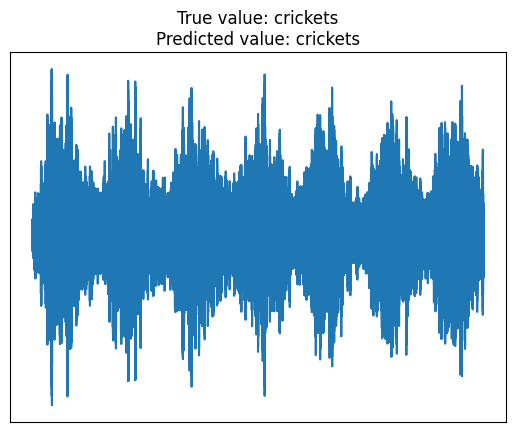

In [ ]:
I = 436

filepath = df.loc[I, "filename"]
category = df.loc[I,"category"]
target = df.loc[I,"target"]

x, _ = librosa.load(filepath_audio + filepath, sr=44100)

parallel_CNN = tf.keras.models.load_model(filepath_parallel_CNN)

spec = parallel_CNN_spectrogram(x)
pred = np.argmax(parallel_CNN.predict(spec[None,:,:,None]))

title = f'True value: {class_dict[target]}\nPredicted value: {class_dict[pred]}'
show_waveform(x, title = title)

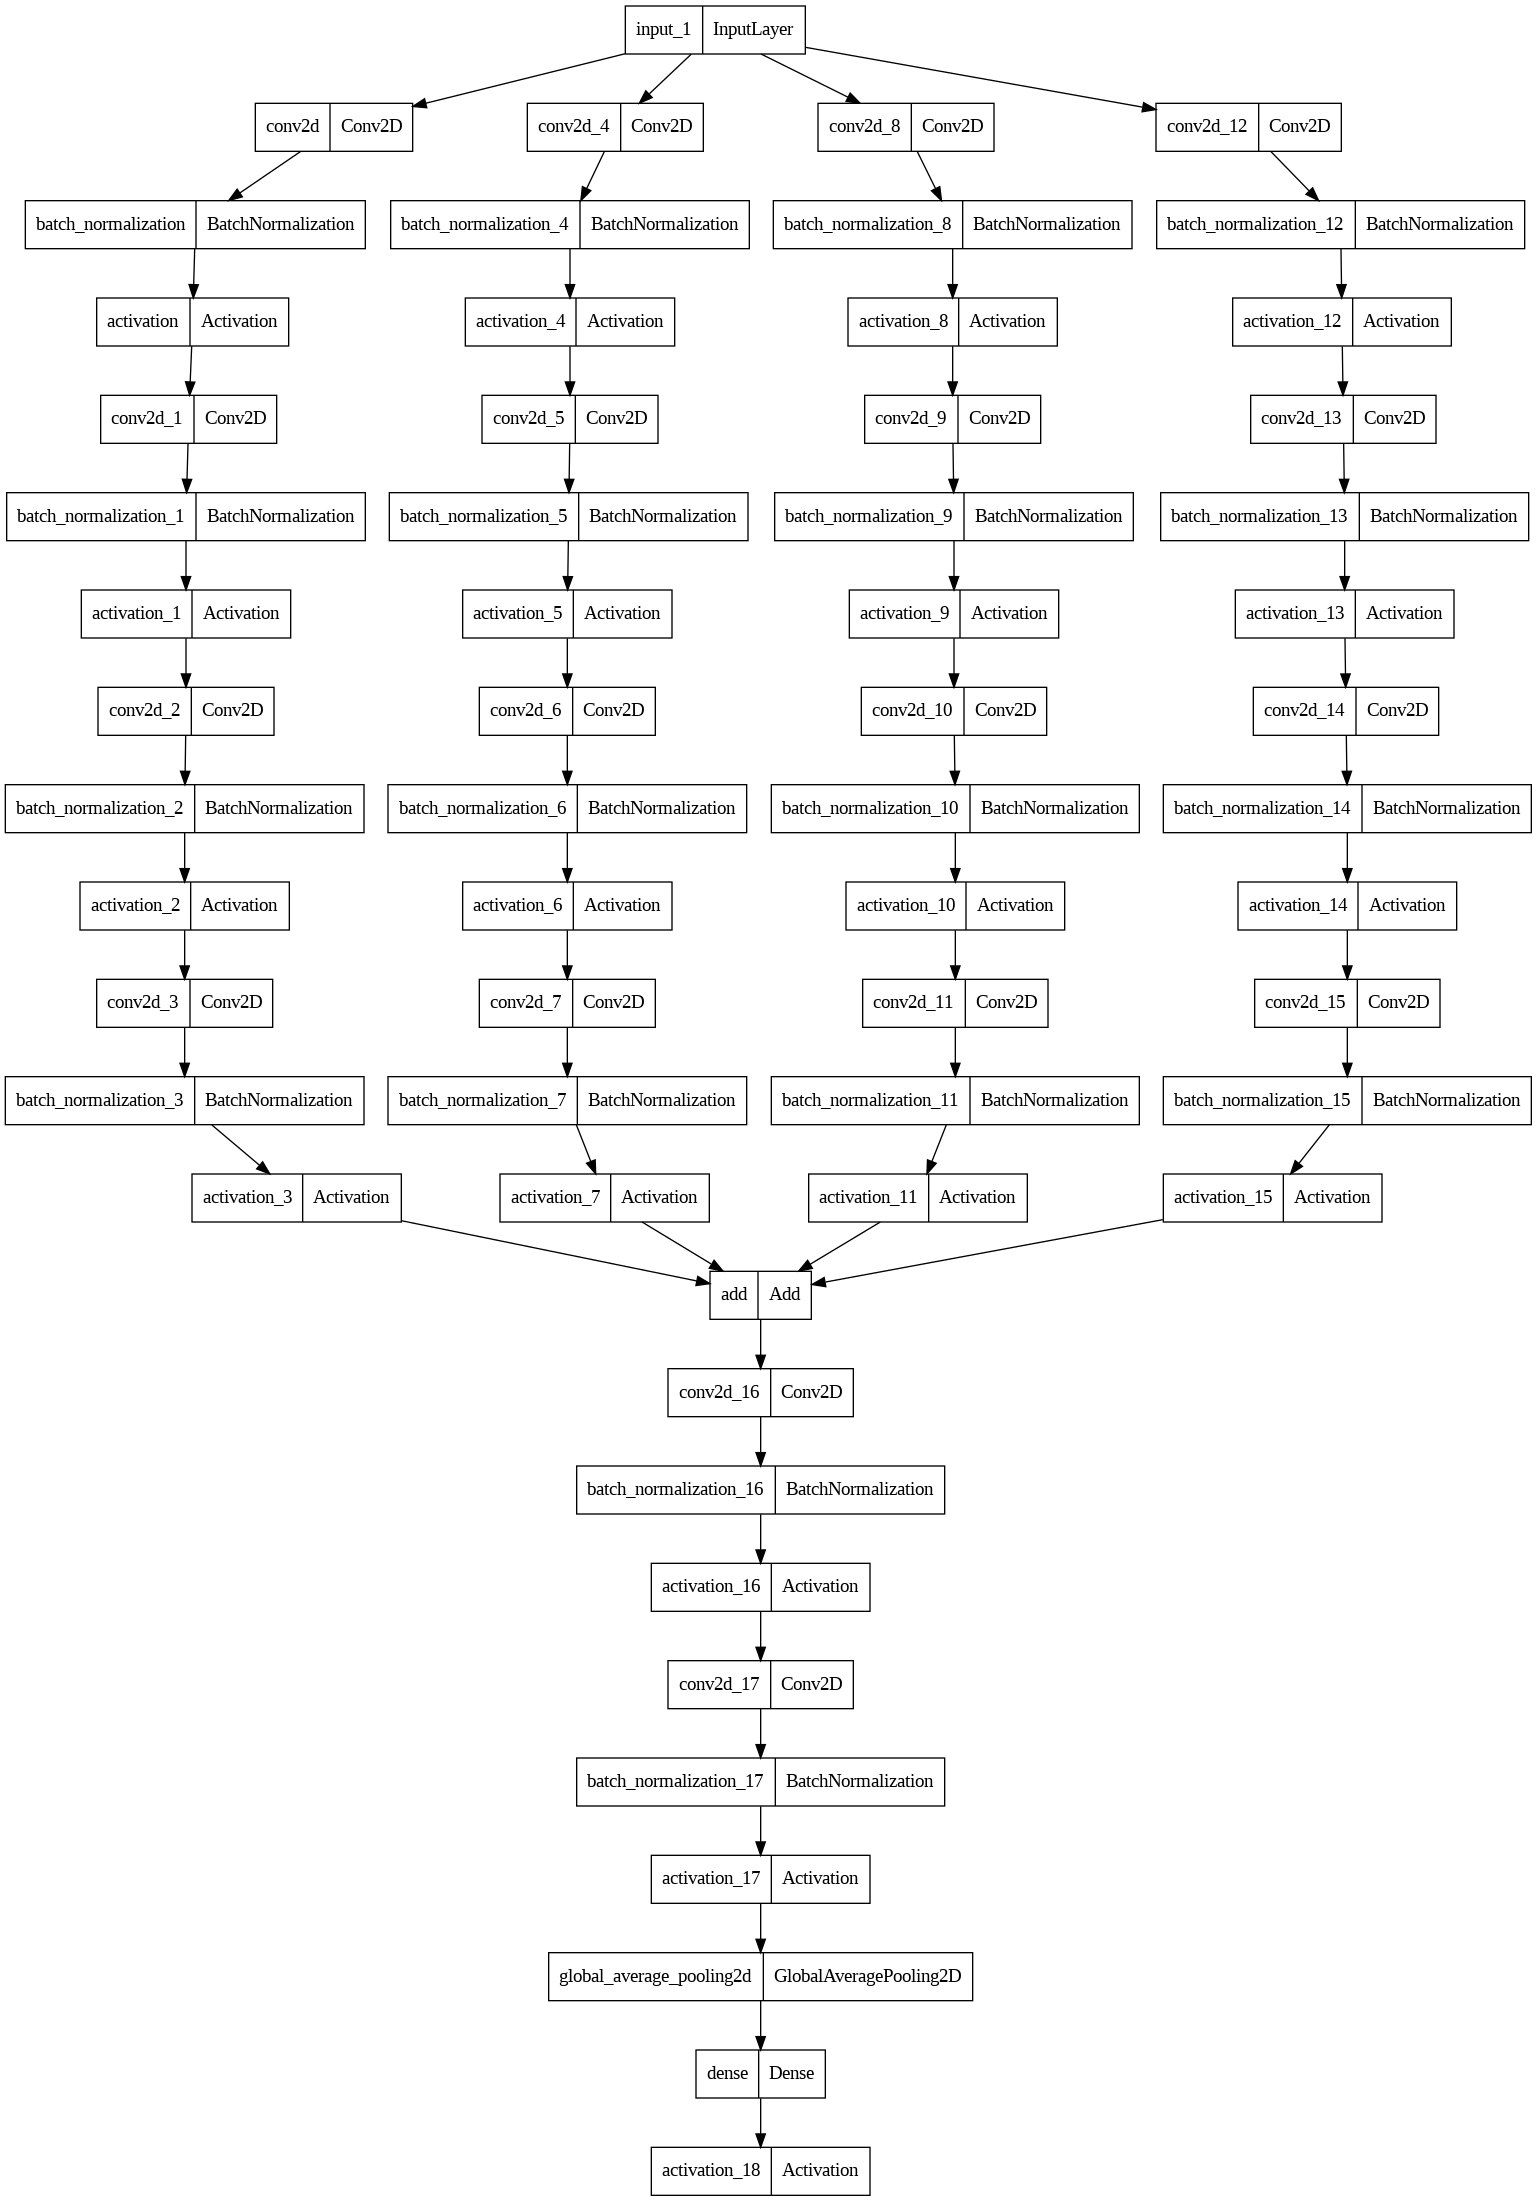

In [ ]:
# if you wanna see the model architectures:

from tensorflow.keras.utils import plot_model

# plot_model(sequential_CNN)
plot_model(parallel_CNN)